# Hackerearth Twitter Sentiment Analysis #

In [68]:
##### libraries #####

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##### NPL libraries ######
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk 
import string
import re

##### dimensionality reduction #######
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

##### machine learning ######
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgbm
import xgboost as xgboost
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Loading the dataset 

train = pd.read_csv('train.csv')
test =pd.read_csv('test.csv')

train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [4]:
test.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


## Class Imbalance Analysis

/Users/girishdevkumarchaurasiya/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


<Figure size 1500x800 with 0 Axes>

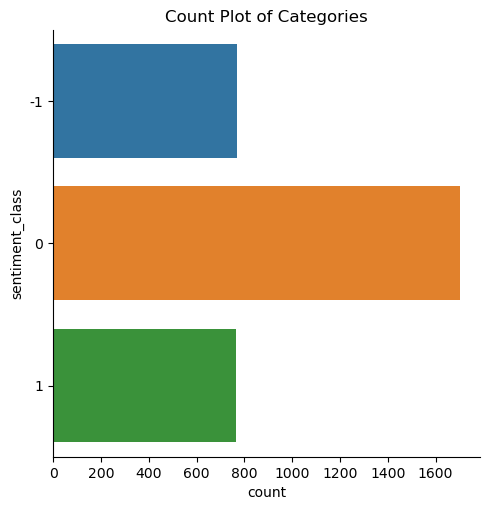

In [14]:
# Create a figure
ch = plt.figure(figsize=(15, 8))

# Plot a count of sentiment classes
sns.catplot(data=train, y='sentiment_class', kind='count', ax=ch)

# Comment on class imbalance
# Approximately 50% of sentiments are neutral, while only 25% each are positive and negative.

plt.title('Count Plot of Categories')

# Save the figure
plt.savefig('cat_count.png', pad_inches=0.01)

# Author Analysis

In [15]:
# Create a DataFrame with the count of original authors
original_authors_train = pd.DataFrame(train['original_author'].value_counts())

# Display the top 320 authors with the most tweets
original_authors_train['original_author'].head(320)

# Comment on authors with multiple tweets
# Approximately 300 users have more than one tweet.

# Perform a join operation to see sentiment variation by original author
train.groupby(['original_author', 'sentiment_class'])['id'].count().tail(40)

# Comment on sentiment variation among authors
# Some authors have both positive and neutral tweets, but most users tweeting neutral tend to remain neutral.
# Authors could be a useful feature.

original_author  sentiment_class
unicorn_little_   0                 1
vaibhavGhevde     0                 1
vaohti           -1                 1
vicebusting       1                 1
vintagerenewed    0                 1
vintagobsession   0                 1
                  1                 1
vishwas211085     0                 1
vocalbeing        0                 1
waelmusaa         0                 1
wakingupfree      1                 1
walkingSpegiddo  -1                 1
waltersjewelers  -1                 1
                  0                 1
warnerbrostv      0                 1
wellsleeprelax    0                 2
whitebrownsugar   0                 1
wifewithgirls    -1                 1
                  0                 1
wiililsunflower   0                 1
windowtonews     -1                 1
womenswordtoday   1                 1
wonderBmarie     -1                 1
wow10shop         1                 1
wwwgalelaurecom   0                 1
wyann            

## Retweet Count Analysis

In [74]:
# Display the count distribution of retweet counts
train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')].groupby(['sentiment_class', 'retweet_count'])['id'].count().head(60)

# Convert and clean the retweet count data
feature_retweet = pd.to_numeric(train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')]['retweet_count']).round().abs()
feature_retweet[True == train['retweet_count'].str.contains(r'[a-zA-Z]')] = 0

# Check for missing values in the retweet count
feature_retweet.isnull().sum()

# Group and count retweets for a specific sentiment class
train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')][train['sentiment_class'] == 1].groupby(['sentiment_class', 'retweet_count'])['id'].count()

# Comment on the significance of retweet counts
# It's not very clear if retweet counts will play a major role, but for now, let's retain them.


/var/folders/yh/h3t886pn0lg_v3wj0wcsp4y40000gn/T/ipykernel_4735/3872982758.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')][train['sentiment_class'] == 1].groupby(['sentiment_class', 'retweet_count'])['id'].count()


sentiment_class  retweet_count
1                0                636
                 1                 61
                 10                 1
                 118                1
                 14                 2
                 15                 1
                 18                 2
                 2                 22
                 20                 1
                 21                 1
                 24                 1
                 25                 1
                 3                 15
                 32                 1
                 37                 1
                 4                  7
                 45                 1
                 5                  4
                 6                  3
                 8                  3
Name: id, dtype: int64

In [76]:
train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')][train['sentiment_class'] == -1].groupby(['sentiment_class', 'retweet_count'])['id'].count()


/var/folders/yh/h3t886pn0lg_v3wj0wcsp4y40000gn/T/ipykernel_4735/1853538999.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')][train['sentiment_class'] == -1].groupby(['sentiment_class', 'retweet_count'])['id'].count()


sentiment_class  retweet_count
-1               0                639
                 1                 81
                 10                 1
                 11                 2
                 16                 1
                 17                 1
                 18                 1
                 2                 16
                 28                 1
                 3                  6
                 32                 1
                 35                 1
                 4                  5
                 5                  5
                 6                  2
                 61                 1
                 7                  2
                 8                  2
                 9                  1
Name: id, dtype: int64

In [79]:
train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')][train['sentiment_class'] == 0].groupby(['sentiment_class', 'retweet_count'])['id'].count()


/var/folders/yh/h3t886pn0lg_v3wj0wcsp4y40000gn/T/ipykernel_4735/1736252232.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train[False == train['retweet_count'].str.contains(r'[a-zA-Z]')][train['sentiment_class'] == 0].groupby(['sentiment_class', 'retweet_count'])['id'].count()


sentiment_class  retweet_count
0                -0.057256529        1
                 -0.1417566007       1
                 -0.3101107397       1
                 -0.3643299313       1
                 -0.4199361695       1
                 -0.4666353157       1
                 -0.5267869213       1
                 -0.5391119831       1
                 -0.7229893804       1
                 -0.7272841814       1
                 -0.8020153269       1
                 -0.8614161431       1
                 -0.9278231369       1
                 -0.9319417873       1
                 -0.9386981134       1
                 0                1246
                 0.0375273346        1
                 0.1005978336        1
                 0.1078812656        1
                 0.1869516081        1
                 0.2255471156        1
                 0.2356132752        1
                 0.2705365837        1
                 0.3091754197        1
                 0.4005356538    

## Language Analysis

In [75]:
# Display language distribution in the training dataset
print(train['lang'].value_counts())

# Display language distribution in the test dataset
print(test['lang'].value_counts())

# Comment on language data
# Despite some noise in the data, we can safely assume that all tweets are in English.


en                            2994
 pink Peruvian opal! via         4
WORLDS OKAYEST MOTHER! &lt       2
 Find More                       2
&gt                              2
                              ... 
0.0492668521                     1
0.0225309145                     1
0.2871981974                     1
0.8644551076                     1
0.2522315249                     1
Name: lang, Length: 232, dtype: int64
en                            1304
 pink Peruvian opal! via         3
WORLDS OKAYEST MOTHER! &lt       2
-0.7323410974                    1
0.2300312771                     1
                              ... 
0.0576878645                     1
-0.8241451498                    1
0.7133047855                     1
0.8899117476                     1
-0.8393813523                    1
Name: lang, Length: 81, dtype: int64


## Tweet Text Analysis

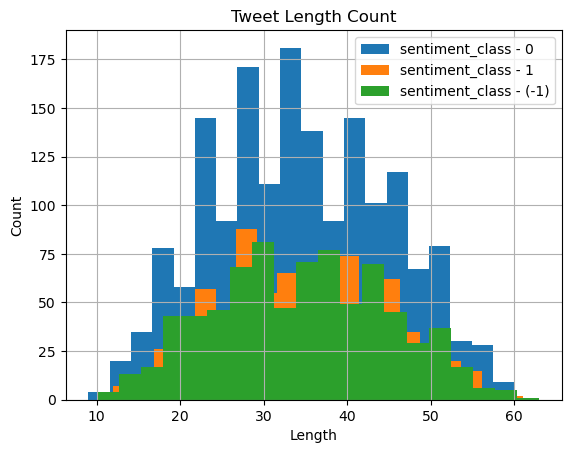

In [18]:
# Create a figure for text length analysis
ch_dist = plt.figure()

# Plot histograms of text length for different sentiment classes
train[train['sentiment_class'] == 0]['original_text'].str.split().apply(len).hist(bins=20, legend=True)
train[train['sentiment_class'] == 1]['original_text'].str.split().apply(len).hist(bins=20, legend=True)
train[train['sentiment_class'] == -1]['original_text'].str.split().apply(len).hist(bins=20, legend=True)

# Comment on text length distribution
# There is a fairly even distribution of text length across different sentiment classes.

# Set titles and labels for the text length analysis
plt.title("Tweet Length Count")
plt.xlabel("Length")
plt.ylabel("Count")

# Add a legend
plt.legend(['sentiment_class - 0', 'sentiment_class - 1', 'sentiment_class - (-1)'])

# Save the figure
ch_dist.savefig('cat_distr.png')

# End of the analysis

## count vectorizer and word cloud

(3235, 14852)


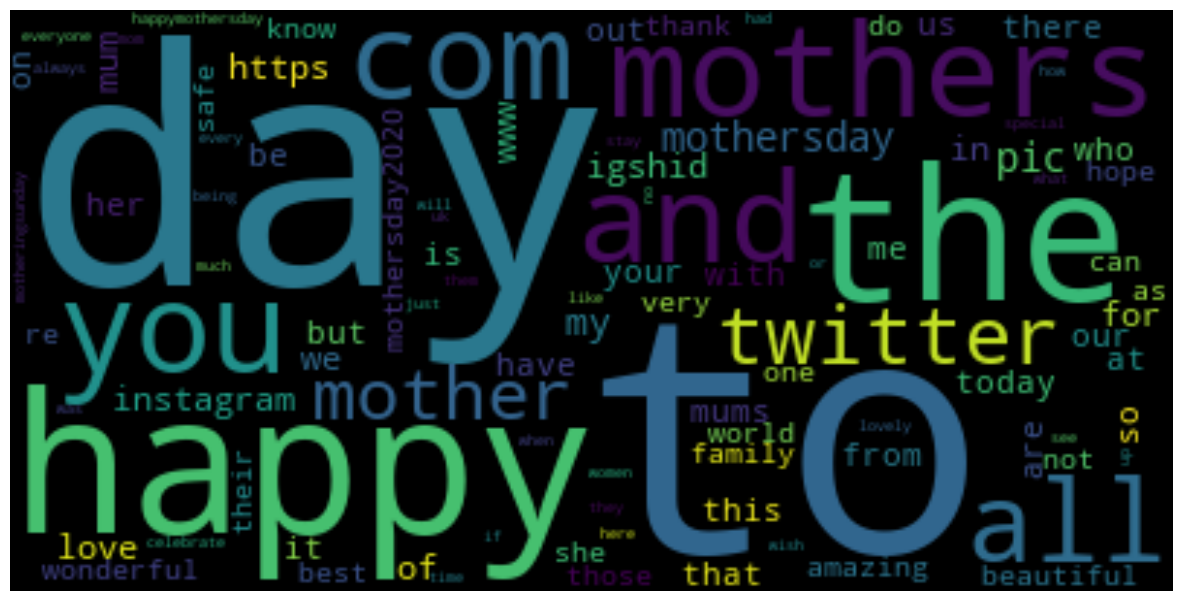

In [22]:
# Create a CountVectorizer
vectorizer = CountVectorizer()

# Transform the text data
X = vectorizer.fit_transform(list(train['original_text']))

# Display the shape of the resulting matrix
print(X.toarray().shape)

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense matrix and then to a DataFrame
dense = X.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

# Generate a Word Cloud based on word frequencies
Cloud = WordCloud(background_color="black", max_words=100).generate_from_frequencies(df.T.sum(axis=1))

# Create a figure for the Word Cloud
ch = plt.figure(figsize=(15, 10))

# Display the Word Cloud with appropriate settings
plt.imshow(Cloud, interpolation='bilinear')
plt.axis("off")

# Save the Word Cloud as an image
plt.savefig('word_cloud.png')

# Show the Word Cloud
plt.show()


# summary #

# Common Words like "happy," "mother," and "day" are frequent and may not be ideal features. #
# Consider reducing their importance or excluding them from the feature set. #

## Tfidf vectorizer and word cloud

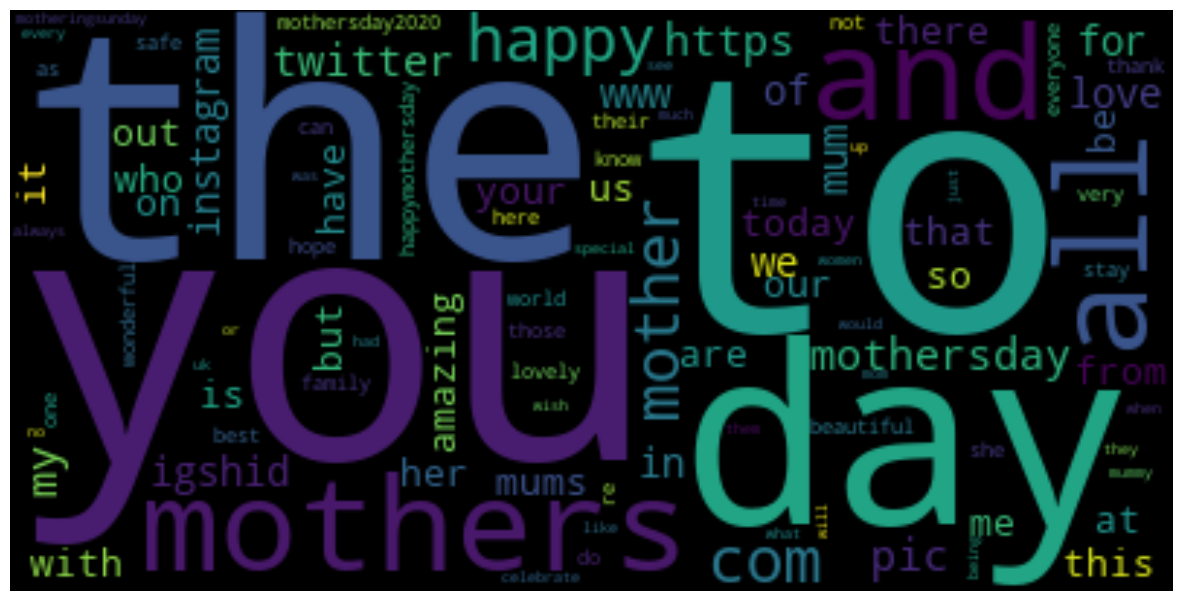

In [39]:
# Create a TF-IDF Vectorizer with specific settings
tfidfvectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=2000)

# Transform the training text data using the TF-IDF Vectorizer
X_train_tfidf = tfidfvectorizer.fit_transform(list(train['original_text']))

# Get the feature names from the TF-IDF Vectorizer
feature_names = tfidfvectorizer.get_feature_names_out()

# Convert the sparse TF-IDF matrix to a dense matrix and then to a DataFrame
dense_tfidf = X_train_tfidf.todense()
lst2 = dense_tfidf.tolist()
df_tfidf = pd.DataFrame(lst2, columns=feature_names)

# Generate a Word Cloud based on TF-IDF weighted word frequencies
Cloud_tfidf = WordCloud(background_color="black", 
                        max_words=100).generate_from_frequencies(df_tfidf.T.sum(axis=1))

# Create a figure for the TF-IDF Word Cloud
ch = plt.figure(figsize=(15, 10))

# Display the Word Cloud with appropriate settings
plt.imshow(Cloud_tfidf, interpolation='bilinear')
plt.axis("off")

# Save the TF-IDF Word Cloud as an image
plt.savefig('word_cloud.png')

# Show the TF-IDF Word Cloud
plt.show()

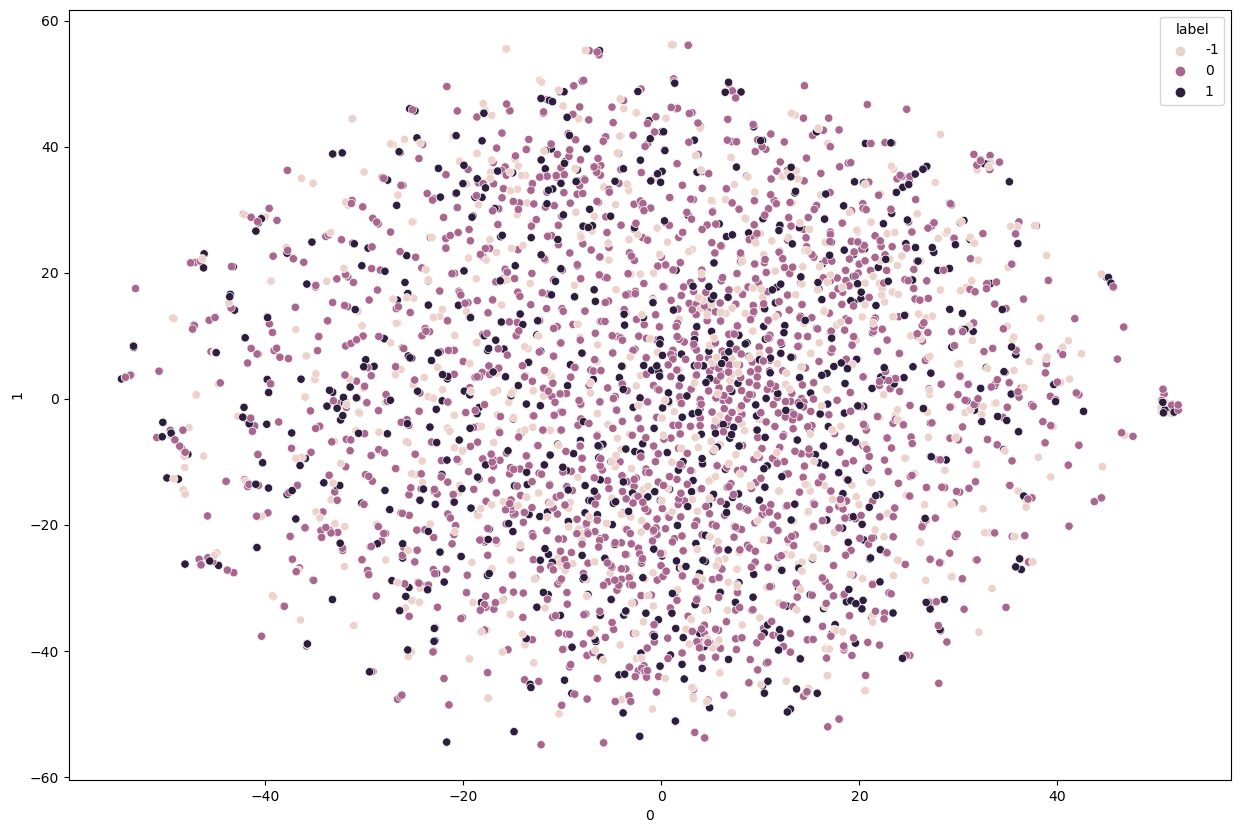

In [40]:
# Convert X_train to a dense DataFrame
X_train_tfidf = X_train_tfidf.toarray()
X_train_tfidf = pd.DataFrame(data=X_train_tfidf, 
                       index=np.arange(X_train_tfidf.shape[0]), 
                       columns=np.arange(X_train_tfidf.shape[1]))

# Perform t-SNE dimensionality reduction to 2 components
X_embedded = TSNE(n_components=2).fit_transform(X_train_tfidf)

# Check the shape of the resulting embedded data
X_embedded.shape

# Create a DataFrame for the embedded data
X_embedded = pd.DataFrame(data=X_embedded, 
                          index=np.arange(X_embedded.shape[0]), 
                          columns=np.arange(X_embedded.shape[1]))

# Add the 'sentiment_class' column to the embedded data
X_embedded['label'] = train['sentiment_class']

# Create a scatterplot to visualize the data
plt.figure(figsize=(15, 10))
sns.scatterplot(x=0, 
                y=1, 
                hue="label", 
                data=X_embedded)

# Save the scatterplot as an image
plt.savefig('scatter.png')

# Comment on the visualization
# This visualization suggests that there is no apparent pattern in the data after t-SNE dimensionality reduction.
# We can still proceed to model using various classifiers and evaluate their performance on the validation data.

# Classification #

In [41]:
# Prepare the feature matrix 'X' for modeling
X = X_train_tfidf.copy()  # Copy X_train_tfidf as the feature matrix

# Add feature columns for retweet_count and original_author
X['retweet_count'] = feature_retweet
X['original_author'] = train['original_author']

# Display the first few rows of the training data
display('Training data:', X.head())

# Initialize a LabelEncoder for encoding the 'original_author' feature
le = preprocessing.LabelEncoder()

# Fit the LabelEncoder on the 'original_author' column
le.fit(X['original_author'])

# Display the classes after encoding
display('Classes:', le.classes_)

# Transform the 'original_author' column with the encoded labels
X['original_author'] = le.transform(X['original_author'])

# Display the first few rows of the training data after encoding
display('Training data:', X.head())

# Add a feature column for text_length
X['text_length'] = train['original_text'].str.split().apply(len)

# Fill any missing values with 0
X = X.fillna(0)

# Get the target variable 'y' (sentiment_class)
y = train['sentiment_class']

# Ensure column names are of string data type
X.columns = X.columns.astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

'Training data:'

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,retweet_count,original_author
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BeenXXPired
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,FestiveFeeling
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KrisAllenSak
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Queenuchee
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,brittan17446794


'Classes:'

array(['-0.3350875182', '-0.6227238527', '-0.7512809757', ..., 'zkozkohi',
       'zsamstore', '|&gt'], dtype=object)

'Training data:'

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,retweet_count,original_author
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,336
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,485
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,718
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1018


In [47]:
############# Creating a Logistic Regression-based model ###############

# Initialize the Logistic Regression classifier
clf = LogisticRegression(max_iter=10000)

# Train the model on the training data
model = clf.fit(X_train, y_train)

# Make predictions on the test data
pred_test = model.predict(X_test)

# Calculate and display the weighted F1 score
display(f1_score(pred_test, y_test, average='weighted'))

# Display the confusion matrix
display(confusion_matrix(pred_test, y_test))

############# Creating a Naive Bayes-based model ###############

# Initialize the Gaussian Naive Bayes classifier
clf = GaussianNB()

# Train the model on the training data
model = clf.fit(X_train, y_train)

# Make predictions on the test data
pred_test = model.predict(X_test)

# Calculate and display the weighted F1 score
display(f1_score(y_test, pred_test, average='weighted'))

# Display the confusion matrix
display(confusion_matrix(pred_test, y_test))

############# Creating an LGBM-based model ###############

# Initialize the LGBM classifier
clf = lgbm.sklearn.LGBMClassifier()

# Train the model on the training data
model = clf.fit(X_train, y_train)

# Make predictions on the test data
pred_test = model.predict(X_test)

# Calculate and display the weighted F1 score
display(f1_score(pred_test, y_test, average='weighted'))

# Display the confusion matrix
display(confusion_matrix(pred_test, y_test))

0.5568079536724111

array([[ 22,  30,  14],
       [151, 353, 162],
       [ 19,  43,  15]])

0.3268270886331537

array([[ 84, 171,  80],
       [ 56, 112,  47],
       [ 52, 143,  64]])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.338744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15927
[LightGBM] [Info] Number of data points in the train set: 2426, number of used features: 394
[LightGBM] [Info] Start training from score -1.436157
[LightGBM] [Info] Start training from score -0.643298
[LightGBM] [Info] Start training from score -1.441370


0.5118339498488267

array([[ 26,  45,  27],
       [138, 318, 128],
       [ 28,  63,  36]])

In [80]:
############## Let's create a setup to calculate an LGBM-based model ##############

# Combine the training and test data (Full_data) without the 'sentiment_class' column
Full_data = train.drop('sentiment_class', axis=1)
Full_data = pd.concat([Full_data, test], ignore_index=True)

# Initialize a TF-IDF Vectorizer with specific settings
tfidfvectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=20000)

# Transform the original text into TF-IDF features
Y = tfidfvectorizer.fit_transform(list(Full_data['original_text']))

# Apply Truncated Singular Value Decomposition (SVD) to reduce dimensionality
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X = svd.fit_transform(Y)

# Convert the SVD output into a DataFrame
X = pd.DataFrame(data=X, index=range(X.shape[0]), columns=range(X.shape[1]))

# Extract and process the retweet_count feature
feature_retweet = pd.to_numeric(Full_data[False == Full_data['retweet_count'].\
                                          str.contains(r'[a-zA-Z]')]['retweet_count']).round().abs()
X['retweet_count'] = feature_retweet

# Add a feature column for text_length
X['text_length'] = Full_data['original_text'].str.split().apply(len)

# Initialize a LabelEncoder for encoding the 'original_author' feature
le = preprocessing.LabelEncoder()

# Fit the LabelEncoder on the 'original_author' column
le.fit(Full_data['original_author'])

# Display the classes after encoding
display(le.classes_)

# Transform the 'original_author' column with the encoded labels
X['original_author'] = le.transform(Full_data['original_author'])

# Split the data back into training and testing sets
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]
y_train = train['sentiment_class']

# Initialize the LGBM classifier
clf = lgbm.sklearn.LGBMClassifier(random_state=42)

# Train the model on the training data
model = clf.fit(X_train, y_train)

# Predict on the training data and calculate the weighted F1 score
y_train_pred = model.predict(X_train)

display(f1_score(y_train_pred, y_train, average='weighted'))

# Predict on the test data
pred = model.predict(X_test)

# Prepare the submission DataFrame and save it to a CSV file
sub = pd.DataFrame()
sub['id'] = test['id']
sub['sentiment_class'] = pred
sub.to_csv('submission.csv', index=False)

# This serves as our baseline with a test score of 41.92 and a weighted F1 score

array(['-0.0609223143', '-0.3350875182', '-0.5266223935', ..., 'zoeleonu',
       'zsamstore', '|&gt'], dtype=object)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13081
[LightGBM] [Info] Number of data points in the train set: 3235, number of used features: 53
[LightGBM] [Info] Start training from score -1.436693
[LightGBM] [Info] Start training from score -0.642813
[LightGBM] [Info] Start training from score -1.441908


0.995985407041603

In [73]:
####################### Text Cleaning Steps ##########################

# Steps:
# 1. Remove punctuations
# 2. Tokenization: Convert a sentence into a list of words
# 3. Remove stopwords
# 4. Lemmatization/Stemming: Transform any word form to its root word

# Remove punctuations from the 'original_text' column

tweets = Full_data['original_text']
display(string.punctuation)

def remove_punct(tweet):
    # Remove punctuation characters
    tweet = "".join([char for char in tweet if char not in string.punctuation])
    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)
    return tweet

tweets = tweets.apply(lambda x: remove_punct(x))
display(tweets.head(10))

# Tokenize the text by splitting into words

def tokenization(tweet):
    tweet = re.split('\W+', tweet)
    return tweet

tweets = tweets.apply(lambda x: tokenization(x))
display(tweets.head(10))

# Remove stopwords using NLTK stopwords list

stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(tweet):
    tweet = [word for word in tweet if word not in stopwords]
    return tweet

tweets = tweets.apply(lambda x: remove_stopwords(x))
display(tweets.head(10))

# Perform stemming using Porter Stemmer

ps = nltk.PorterStemmer()

def stemming(tweet):
    tweet = [ps.stem(word) for word in tweet]
    return tweet

tweets = tweets.apply(lambda x: stemming(x))
display(tweets.head(10))

# Perform lemmatization using WordNet Lemmatizer

wn = nltk.WordNetLemmatizer()

def lemmatizer(tweet):
    tweet = [wn.lemmatize(word) for word in tweet]
    return tweet

tweets = tweets.apply(lambda x: lemmatizer(x))
display(tweets.head(10))

# Join the tokenized words to create clean text

tweets = tweets.apply(lambda x: ' '.join(x))
display(tweets.head(10))


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

0    Happy MothersDay to all you amazing mothers ou...
1    Happy Mothers Day Mum  Im sorry I cant be ther...
2    Happy mothers day To all This doing a mothers ...
3    Happy mothers day to this beautiful womanroyal...
4    Remembering the  most amazing ladies who made ...
5    HAPPY MOTHER’S DAY BRATZ WORLD FAMILIEZ YASMIN...
6    Happy Mother’s Day to all you wonderful mums o...
7    Show me a mother of two as sexy as Rosie Happy...
8    To all the mothers grandmothers aunts sisters ...
9    To all the mothers around the World Gas To Hea...
Name: original_text, dtype: object

0    [Happy, MothersDay, to, all, you, amazing, mot...
1    [Happy, Mothers, Day, Mum, Im, sorry, I, cant,...
2    [Happy, mothers, day, To, all, This, doing, a,...
3    [Happy, mothers, day, to, this, beautiful, wom...
4    [Remembering, the, most, amazing, ladies, who,...
5    [HAPPY, MOTHER, S, DAY, BRATZ, WORLD, FAMILIEZ...
6    [Happy, Mother, s, Day, to, all, you, wonderfu...
7    [Show, me, a, mother, of, two, as, sexy, as, R...
8    [To, all, the, mothers, grandmothers, aunts, s...
9    [To, all, the, mothers, around, the, World, Ga...
Name: original_text, dtype: object

0    [Happy, MothersDay, amazing, mothers, I, know,...
1    [Happy, Mothers, Day, Mum, Im, sorry, I, cant,...
2    [Happy, mothers, day, To, This, mothers, days,...
3    [Happy, mothers, day, beautiful, womanroyalty,...
4    [Remembering, amazing, ladies, made, I, My, la...
5    [HAPPY, MOTHER, S, DAY, BRATZ, WORLD, FAMILIEZ...
6    [Happy, Mother, Day, wonderful, mums, mothersd...
7    [Show, mother, two, sexy, Rosie, Happy, Mother...
8    [To, mothers, grandmothers, aunts, sisters, wo...
9    [To, mothers, around, World, Gas, To, Health, ...
Name: original_text, dtype: object

0    [happi, mothersday, amaz, mother, i, know, har...
1    [happi, mother, day, mum, im, sorri, i, cant, ...
2    [happi, mother, day, to, thi, mother, day, wor...
3    [happi, mother, day, beauti, womanroyalti, soo...
4    [rememb, amaz, ladi, made, i, my, late, grandm...
5    [happi, mother, s, day, bratz, world, familiez...
6    [happi, mother, day, wonder, mum, mothersday, ...
7    [show, mother, two, sexi, rosi, happi, mother,...
8    [to, mother, grandmoth, aunt, sister, women, l...
9    [to, mother, around, world, ga, to, health, in...
Name: original_text, dtype: object

0    [happi, mothersday, amaz, mother, i, know, har...
1    [happi, mother, day, mum, im, sorri, i, cant, ...
2    [happi, mother, day, to, thi, mother, day, wor...
3    [happi, mother, day, beauti, womanroyalti, soo...
4    [rememb, amaz, ladi, made, i, my, late, grandm...
5    [happi, mother, s, day, bratz, world, familiez...
6    [happi, mother, day, wonder, mum, mothersday, ...
7    [show, mother, two, sexi, rosi, happi, mother,...
8    [to, mother, grandmoth, aunt, sister, woman, l...
9    [to, mother, around, world, ga, to, health, in...
Name: original_text, dtype: object

0    happi mothersday amaz mother i know hard abl s...
1    happi mother day mum im sorri i cant bring mot...
2    happi mother day to thi mother day work today ...
3    happi mother day beauti womanroyalti sooth mum...
4    rememb amaz ladi made i my late grandmoth iri ...
5    happi mother s day bratz world familiez yasmin...
6    happi mother day wonder mum mothersday cupcak ...
7    show mother two sexi rosi happi mother day bea...
8    to mother grandmoth aunt sister woman live car...
9    to mother around world ga to health initi wish...
Name: original_text, dtype: object

##### we will be combining the train and test data and then prepare a common tf-idf##
##### lgbm  - 43.9

##### 2000 top words in tfidf vector

##### 45 - dimension after truncatedSVD

##### XGB - 44.43 rank 26

##### 2000 - top words in tfidf vector (features)

##### 50 - dimension after truncatedSVD

In [67]:
# Import necessary libraries
from sklearn.decomposition import TruncatedSVD

import lightgbm as lgbm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn import preprocessing

############## Setting up the data and models ##############

# Create a cleaned copy of Full_data
Full_data_cleaned = Full_data.copy()

# Replace the 'original_text' column with 'tweets'
Full_data_cleaned['original_text'] = tweets

# Initialize a TF-IDF Vectorizer with specific settings
tfidfvectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=2000)

# Transform the 'original_text' into TF-IDF features
Y = tfidfvectorizer.fit_transform(list(Full_data['original_text']))

# Apply Truncated Singular Value Decomposition (SVD) for dimensionality reduction
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X = svd.fit_transform(Y)

# Convert the SVD output into a DataFrame
X = pd.DataFrame(data=X, index=range(X.shape[0]), columns=range(X.shape[1]))

# Extract and process the retweet_count feature
feature_retweet = pd.to_numeric(Full_data[False == Full_data['retweet_count'].str.contains(r'[a-zA-Z]')]['retweet_count']).round().abs()
X['retweet_count'] = feature_retweet

# Add a feature column for text_length
X['text_length'] = Full_data['original_text'].str.split().apply(len)

# Initialize a LabelEncoder for encoding the 'original_author' feature
le = preprocessing.LabelEncoder()

# Fit the LabelEncoder on the 'original_author' column
le.fit(Full_data['original_author'])

# Get the classes after encoding
le.classes_

# Transform the 'original_author' column with the encoded labels
X['original_author'] = le.transform(Full_data['original_author'])

# Split the data back into training and testing sets
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]
y_train = train['sentiment_class']

# Initialize the LGBM classifier
clf = lgbm.sklearn.LGBMClassifier(random_state=42)

# Train the LGBM model
model = clf.fit(X_train, y_train)

# Predict on the training data and calculate the weighted F1 score
y_train_pred = model.predict(X_train)
display(f1_score(y_train_pred, y_train, average='weighted'))

# Predict on the test data
pred = model.predict(X_test)

# Prepare and save the submission DataFrame
sub = pd.DataFrame()
sub['id'] = test['id']
sub['sentiment_class'] = pred
sub.to_csv('submission.csv', index=False)

# Prepare data for XGBoost
y_train_xg = y_train + 1

# Initialize the XGBoost classifier
clf = xgboost.sklearn.XGBClassifier(random_state=42)

# Train the XGBoost model
model = clf.fit(X_train, y_train_xg)

# Predict on the training data and calculate the weighted F1 score
y_train_pred = model.predict(X_train)
display(f1_score(y_train_pred, y_train_xg, average='weighted'))
y_test_pred = model.predict(X_test)

# Prepare and save the submission DataFrame

sub=pd.DataFrame()
sub['id'] = test['id']
sub['sentiment_class'] = y_test_pred
sub.to_csv('submission.csv',index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13081
[LightGBM] [Info] Number of data points in the train set: 3235, number of used features: 53
[LightGBM] [Info] Start training from score -1.436693
[LightGBM] [Info] Start training from score -0.642813
[LightGBM] [Info] Start training from score -1.441908


0.9959824724405614

0.999072808257144

In [70]:
################## Stacking LGBM and RF ensemble with XGB as final estimator #######################

#### Note: This configuration didn't perform well. ####

#### We could have considered other models like BERT, ####
#### but we will stop here. ###############

# Fill any missing values with 0 in the training data
X_train = X_train.fillna(0)

# Ensure column names are of string data type
X_train.columns = X_train.columns.astype(str)

# Define a list of estimators for stacking
estimators = [
    ('lgb', lgbm.sklearn.LGBMClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))]

# Initialize the Stacking Classifier with XGB as the final estimator
clf = StackingClassifier(
        estimators=estimators, passthrough=True, final_estimator=xgboost.XGBClassifier(random_state=42))

# Train the Stacking model
model = clf.fit(X_train, y_train)

# Predict on the training data and calculate the weighted F1 score
y_train_pred = model.predict(X_train)
display(f1_score(y_train_pred, y_train, average='weighted'))

# Ensure column names are of string data type in the testing data
X_test=X_test.fillna(0)
X_test.columns = X_test.columns.astype(str)

# Predict on the test data
pred = model.predict(X_test)

# Prepare and save the submission DataFrame
sub = pd.DataFrame()
sub['id'] = test['id']
sub['sentiment_class'] = pred
sub.to_csv('submission.csv', index=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13080
[LightGBM] [Info] Number of data points in the train set: 3235, number of used features: 53
[LightGBM] [Info] Start training from score -1.436693
[LightGBM] [Info] Start training from score -0.642813
[LightGBM] [Info] Start training from score -1.441908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13075
[LightGBM] [Info] Number of data points in the train set: 2588, number of used features: 53
[LightGBM] [Info] Start training from score -1.435394
[LightGBM] [Info] Start training from score -0.643401
[LightGBM] [Info] Start training from score -1.441908
[LightGBM] [Info] Auto-choosing co

0.7069613127865557